In [1]:
from dataset import *
from train import *

In [2]:
list_top_k_candidates = [(20, 30, 40, 50), (60, 70, 80, 90), (100, 110, 120, 130)]
k = 7
temps = 0.7
momentums = 0.99
k_value = 64
parameters = {'top_ks': list_top_k_candidates}
train_metrics = HistoryRecorder(['Train Loss', 'Train Acc', 'Val Loss', 'Val Acc'], list(parameters.keys()))

for parameter in itertools.product(*parameters.values()):

    ### custom part to get parameters
    top_k_candidates = parameter[0]
    ### END
    
    for images in k_fold_train_validation_split(ORIGINAL_IMAGE, TARGET_IMAGE, k):
        train_dataset = ThreeChannelNDIDatasetContrastiveLearningWithAug(images, False)
        val_dataset = ThreeChannelNDIDatasetContrastiveLearningWithAug(images, True)
        train_iter = DataLoader(train_dataset, batch_size=16, shuffle=True, drop_last=True)
        val_iter = DataLoader(val_dataset, batch_size=len(val_dataset))
        model = torchvision.models.resnet50
        model = MoCo(model, dim=512, K=k_value, T=temps, m=momentums, model_type='resnet',
                        weights=ResNet50_Weights.IMAGENET1K_V2, three_channel=True)
        device = torch.device('cuda:0')
        criterion = nn.CrossEntropyLoss().cuda(device)
        optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9, weight_decay=1e-4)
        scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer=optimizer, T_max=100)
        start_time = time.time()
        metrics = train_moco_return_metrics_top_k(model, train_iter, val_iter, criterion, optimizer, 100, device,
                                                    tested_parameter=parameter, k_candidates=top_k_candidates)
        end_time = time.time()
        train_metrics.cal_add(metrics)
train_metrics.cal_divide(k)

Epoch 1, Train_Loss 3.992817187309265, Val_loss 4.2886786460876465
Train_acc_top_20 0.1	Train_acc_top_30 0.1625	Train_acc_top_40 0.2062	Train_acc_top_50 0.2313	
Val_acc_top_20 0.04	Val_acc_top_30 0.12	Val_acc_top_40 0.17	Val_acc_top_50 0.21	
Epoch 2, Train_Loss 4.161376667022705, Val_loss 4.2545318603515625
Train_acc_top_20 0.0813	Train_acc_top_30 0.1688	Train_acc_top_40 0.2188	Train_acc_top_50 0.2625	
Val_acc_top_20 0.08	Val_acc_top_30 0.08	Val_acc_top_40 0.12	Val_acc_top_50 0.17	
Epoch 3, Train_Loss 4.14998230934143, Val_loss 4.233567714691162
Train_acc_top_20 0.1125	Train_acc_top_30 0.1812	Train_acc_top_40 0.2375	Train_acc_top_50 0.275	
Val_acc_top_20 0.04	Val_acc_top_30 0.04	Val_acc_top_40 0.17	Val_acc_top_50 0.21	
Epoch 4, Train_Loss 4.143466758728027, Val_loss 4.2245330810546875
Train_acc_top_20 0.125	Train_acc_top_30 0.2	Train_acc_top_40 0.2562	Train_acc_top_50 0.3125	
Val_acc_top_20 0.04	Val_acc_top_30 0.08	Val_acc_top_40 0.08	Val_acc_top_50 0.08	
Epoch 5, Train_Loss 4.13541774

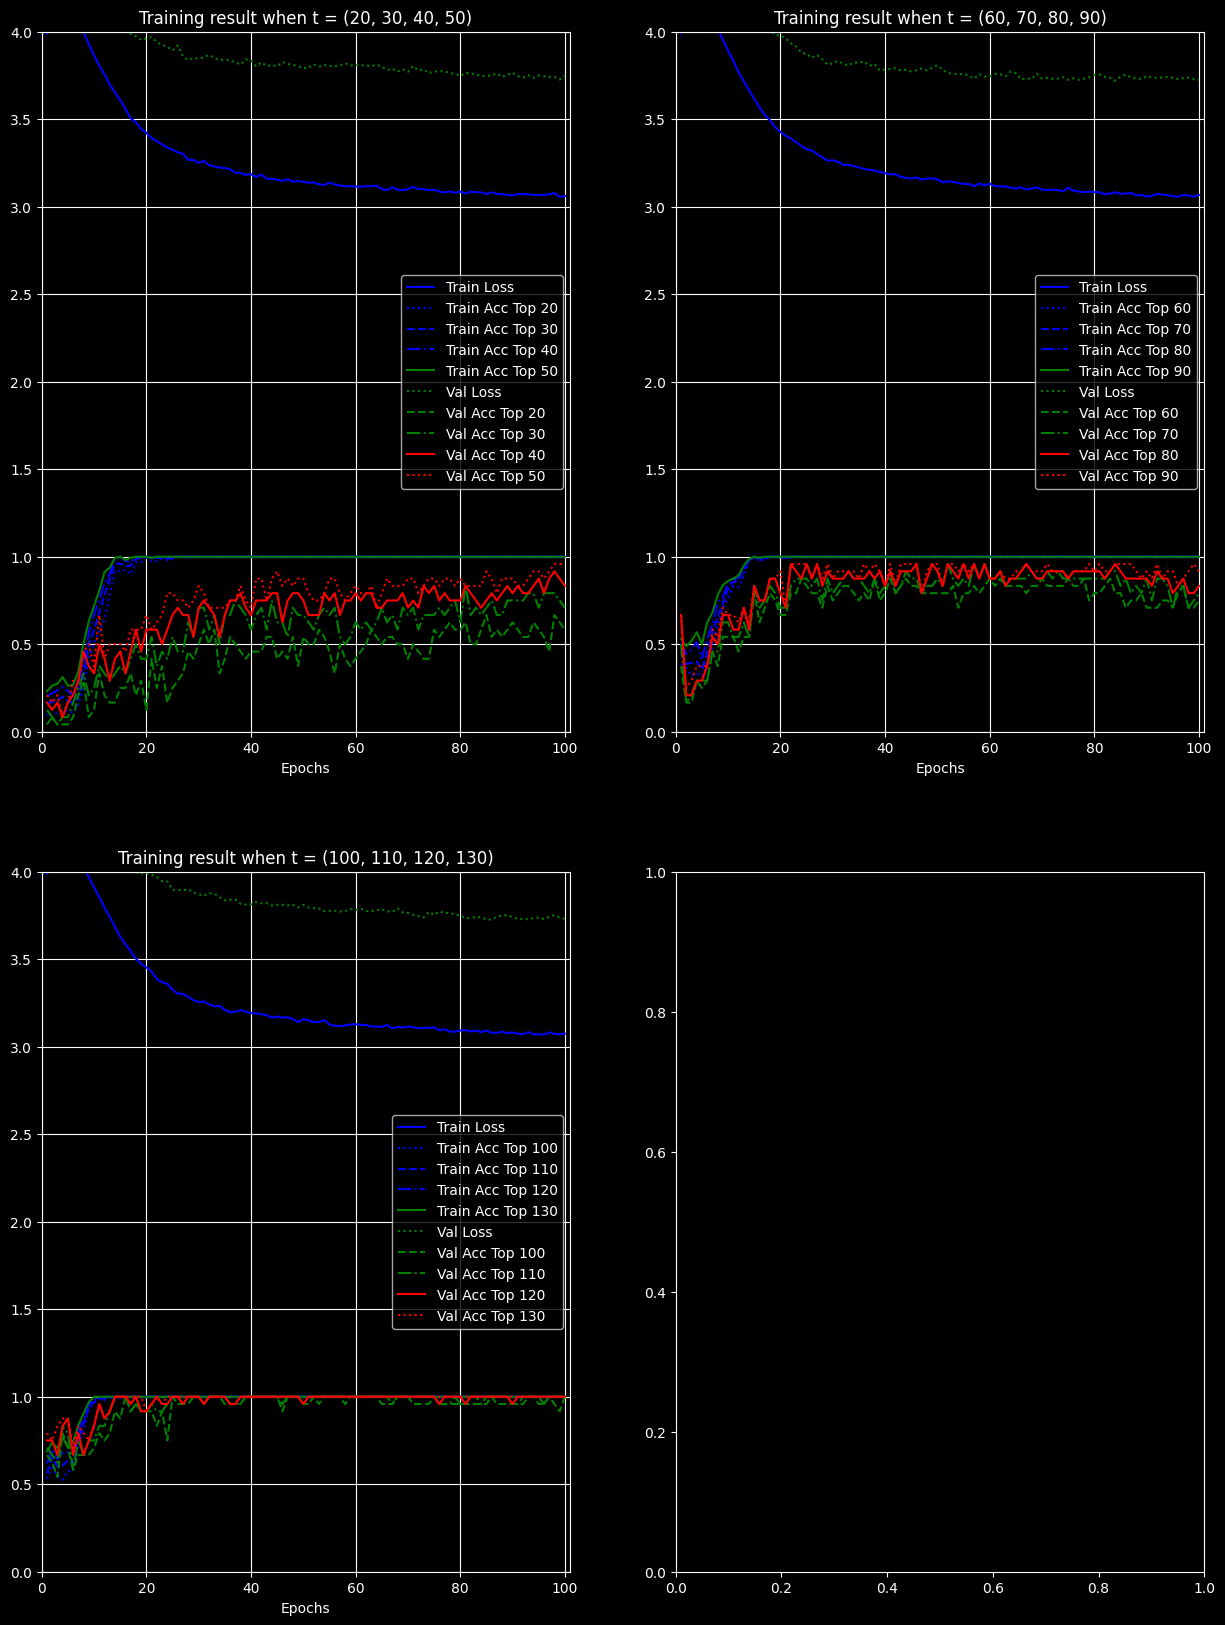

((20, 30, 40, 50),) 20 mean 0.575
((20, 30, 40, 50),) 20 max 0.6666666666666666
((20, 30, 40, 50),) 30 mean 0.7625
((20, 30, 40, 50),) 30 max 0.8333333333333334
((20, 30, 40, 50),) 40 mean 0.8416666666666666
((20, 30, 40, 50),) 40 max 0.9166666666666666
((20, 30, 40, 50),) 50 mean 0.9041666666666668
((20, 30, 40, 50),) 50 max 0.9583333333333334
((60, 70, 80, 90),) 60 mean 0.7416666666666667
((60, 70, 80, 90),) 60 max 0.875
((60, 70, 80, 90),) 70 mean 0.7958333333333334
((60, 70, 80, 90),) 70 max 0.9583333333333334
((60, 70, 80, 90),) 80 mean 0.8416666666666666
((60, 70, 80, 90),) 80 max 0.9583333333333334
((60, 70, 80, 90),) 90 mean 0.9041666666666666
((60, 70, 80, 90),) 90 max 0.9583333333333334
((100, 110, 120, 130),) 100 mean 0.9708333333333334
((100, 110, 120, 130),) 100 max 1.0
((100, 110, 120, 130),) 110 mean 0.9916666666666668
((100, 110, 120, 130),) 110 max 1.0
((100, 110, 120, 130),) 120 mean 1.0
((100, 110, 120, 130),) 120 max 1.0
((100, 110, 120, 130),) 130 mean 1.0
((100, 1

In [4]:
draw_graph(train_metrics.data, 100, ('tok_ks'))
for k, v in train_metrics.data.items():
    for k1 in v[1].keys():
        print(f'{k} {k1} mean {np.mean(v[3][k1][-10:])}')
        print(f'{k} {k1} max {np.max(v[3][k1])}')

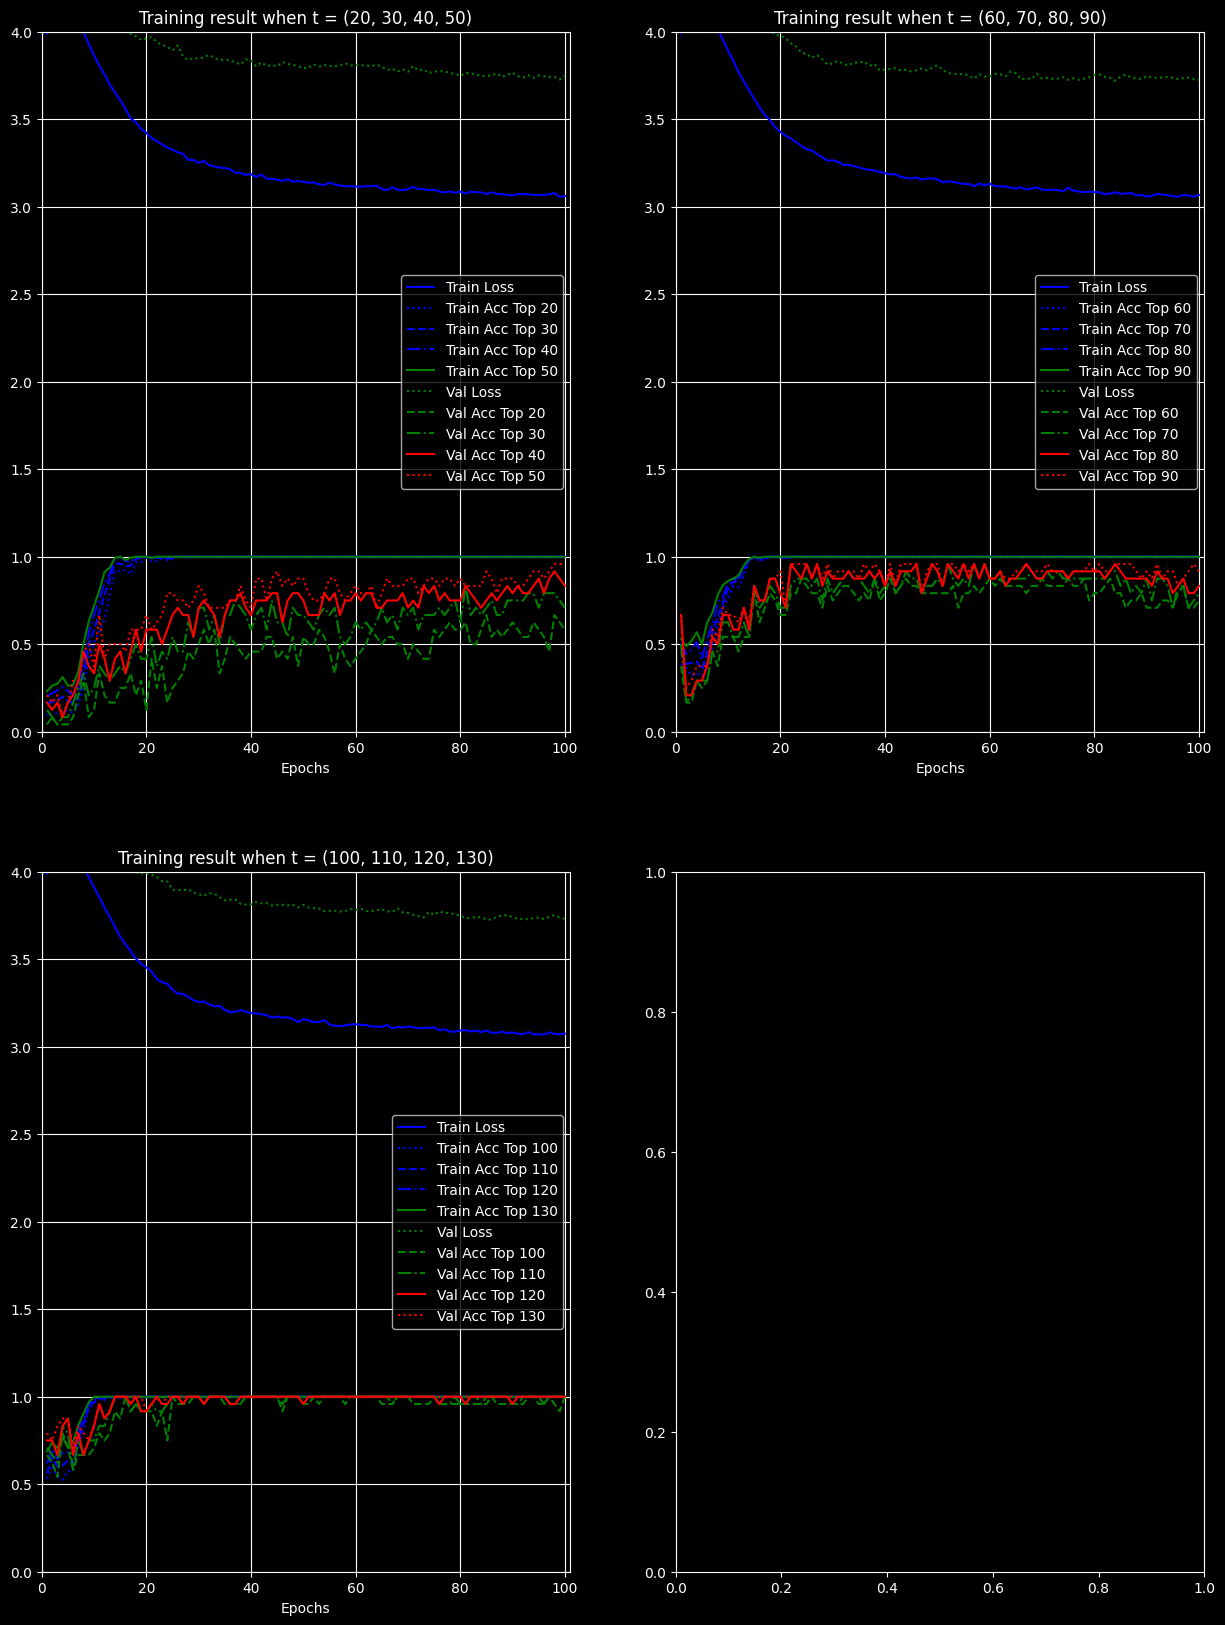

In [15]:
num_epochs = 100
metrics_name = ('tok_ks')
metrics = train_metrics.data

X = np.arange(1, num_epochs + 1, 1)
fig, axes = plt.subplots((len(metrics) + 1) // 2, 2, figsize=(15, 20))
if hasattr(axes, 'flatten'):
    axes = axes.flatten()
else:
    axes = [axes]
for i, (k, v) in enumerate(metrics.items()):
    fmts = fmts_gen()
    plot_data = [v[0]]
    plot_data.extend(v[1].values())
    plot_data.append(v[2])
    plot_data.extend(v[3].values())
    for y, fmt in zip(plot_data, fmts):
        axes[i].plot(X, y, fmt)
    axes[i].set_xlabel('Epochs')
    axes[i].set_xlim([0, num_epochs + 1])
    axes[i].set_ylim([0, 4])
    axes[i].legend(
        ['Train Loss'] + [f'Train Acc Top {k}' for k in v[1].keys()] + ['Val Loss'] + [f'Val Acc Top {k}' for k in
                                                                                        v[3].keys()])
    axes[i].grid()
    axes[i].set_title(
        f'Training result when ' + ', '.join([f'{name} = {value}' for name, value in zip(metrics_name, k)]))
plt.savefig(f'{metrics_name}.png')
plt.show()


In [13]:
np.savetxt('train_metrics.txt', new_dict)

ValueError: Expected 1D or 2D array, got 0D array instead

In [12]:
import json

new_dict = dict([(str(i), j) for i, j in train_metrics.data.items()])
with open('train_metrics.json', 'w') as f:
    json.dump(new_dict, f)

TypeError: Object of type ndarray is not JSON serializable

In [6]:
with open('train_metrics.json', 'w') as f:
    json.dump(train_metrics.data, f)

TypeError: keys must be str, int, float, bool or None, not tuple